# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 11: NNs and Visualizating Prediction Models

**Harvard University**<br>
**Summer 2020**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Pavlos Protopapas, Chris Tanner, Eleni Kaxiras, Kevin Rader

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Table of Contents 
<ol start="0">
<li> Learning Goals </li> 
<li> Brief Tree Review </li>     
<li> Architecture of Artificial Neural Networks (ANNs) </li> 
<li> Variable Importances </li> 
<li> Interpreting Prediction Models </li> 
  

In [2]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import ensemble


# Here are the decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

import tensorflow as tf

print(tf.__version__)  # You should see a 2.0.0 here!

# sns.set(style="ticks")
# %matplotlib inline

2.2.0


## Learning Goals

This Jupyter notebook accompanies Lecture 11. By the end of this lecture, you should be able to:

- have a better grasp of neural network archetecture
- interpret a few different types of variable importances
- interpret a prediction model by exploring the relationships of predictors with the response through prediction plots.


## Part 0: Data Wrangling

For this notebook we will be using the heart data set we've used all semester for performing classification:

In [3]:
heart_df = pd.read_csv('../data/Heart.csv')
print(heart_df.shape)
heart_df.head()

(303, 15)


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [4]:
heart_df.describe()

,Unnamed: 0,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000
mean,152.000000,54.438944,0.679868,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241
std,87.612784,9.038662,0.467299,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438
min,1.000000,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000
25%,76.500000,48.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000
50%,152.000000,56.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000
75%,227.500000,61.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000
max,303.000000,77.000000,1.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000


In [5]:
# Split into X and y
X = heart_df[['Age','Sex','ChestPain','RestBP','Chol','Fbs','RestECG','MaxHR','ExAng','Oldpeak','Slope','Ca','Thal']]
y = 1*(heart_df['AHD']=='Yes')

In [6]:
# fix categorical data types for maching learning methods...don't worry about the warning message

X['ChestPain']=X['ChestPain'].astype('category')
X['ChestPain']=X['ChestPain'].cat.codes

X['Thal']=X['Thal'].astype('category')
X['Thal']=X['Thal'].cat.codes

X.dtypes

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to b

Age            int64
Sex            int64
ChestPain       int8
RestBP         int64
Chol           int64
Fbs            int64
RestECG        int64
MaxHR          int64
ExAng          int64
Oldpeak      float64
Slope          int64
Ca           float64
Thal            int8
dtype: object

In [7]:
# imputing zeroes for the missing values in `CA`

X['Ca']=X['Ca'].fillna(0)

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
X.describe()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,0.841584,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,1.313531
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,-1.000000
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,1.000000
50%,56.000000,1.000000,1.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,1.000000
75%,61.000000,1.000000,1.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,2.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,2.000000


In [9]:
# split into train and test

from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(X.shape[0]), train_size=0.80)

X_train = X.iloc[itrain, :]
X_test = X.iloc[itest, :]
y_train = y.iloc[itrain]
y_test = y.iloc[itest]


## Part 1: tree-based models

Below `max_depth=3` and `max_depth=10` decision trees are fit.

In [10]:
#fit the simple (depth = 3) decision tree classifier
dt3= tree.DecisionTreeClassifier(max_depth = 3)
dt3.fit(X_train,y_train)

#fit the an overfit (depth = 10) decision tree classifier
dt10 = tree.DecisionTreeClassifier(max_depth = 10)
dt10.fit(X_train,y_train)



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

**Q1.1** Calculate the AUC on both train and test, and interpret the results

In [11]:

######
#n Your code here
######

print("AUC on train for dt10:",sk.metrics.roc_auc_score(y_train,dt10.predict_proba(X_train)[:,1]))
print("AUC on test for dt10:",sk.metrics.roc_auc_score(y_test,dt10.predict_proba(X_test)[:,1]))

print("AUC on train for dt3:",sk.metrics.roc_auc_score(y_train,dt3.predict_proba(X_train)[:,1]))
print("AUC on test for dt3:",sk.metrics.roc_auc_score(y_test,dt3.predict_proba(X_test)[:,1]))

AUC on train for dt10: 1.0
AUC on test for dt10: 0.8970588235294118
AUC on train for dt3: 0.8979739010989011
AUC on test for dt3: 0.9515250544662309


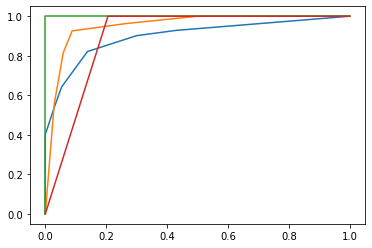

In [12]:
roc_dt3_train = sk.metrics.roc_curve(y_train,dt3.predict_proba(X_train)[:,1], drop_intermediate=False)
plt.plot(roc_dt3_train[0],roc_dt3_train[1]);
roc_dt3_test = sk.metrics.roc_curve(y_test,dt3.predict_proba(X_test)[:,1], drop_intermediate=False)
plt.plot(roc_dt3_test[0],roc_dt3_test[1]);

roc_dt10_train = sk.metrics.roc_curve(y_train,dt10.predict_proba(X_train)[:,1], drop_intermediate=False)
plt.plot(roc_dt10_train[0],roc_dt10_train[1]);
roc_dt10_test = sk.metrics.roc_curve(y_test,dt10.predict_proba(X_test)[:,1], drop_intermediate=False)
plt.plot(roc_dt10_test[0],roc_dt10_test[1]);


**Solution:**

The AUC is higher in train for the more complex tree with depth 10, but is lower in the test set.  This is a clear illustration of overfitting: the model performs will with the same set of data that it was fit on, but performs poorly with out-of-sample data.


We continue fitting tree based models: first with a random forest, and then a boosted tree model.  Note: these are untuned.

In [13]:
np.random.seed(109)
randomforest = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=10)
randomforest.fit(X_train,y_train);

adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=4),
    n_estimators=500,
    learning_rate=.75)
adaboost.fit(X_train,y_train);

In [14]:
# evaluating
print("AUC on train for randomforest:",sk.metrics.roc_auc_score(y_train,randomforest.predict_proba(X_train)[:,1]))
print("AUC on test for randomforest:",sk.metrics.roc_auc_score(y_test,randomforest.predict_proba(X_test)[:,1]))

print("AUC on train for adaboost:",sk.metrics.roc_auc_score(y_train,adaboost.predict_proba(X_train)[:,1]))
print("AUC on test for adaboost:",sk.metrics.roc_auc_score(y_test,adaboost.predict_proba(X_test)[:,1]))

AUC on train for randomforest: 1.0
AUC on test for randomforest: 0.9308278867102396
AUC on train for adaboost: 1.0
AUC on test for adaboost: 0.9052287581699346


**Q1.2** What would happen to the above AUC on train and test (random forest and adaboost) if the number of estimators (base trees) were increased for each?

**Solution:**

The AUC cannot get better on the train set for either model (1.0 is the maximum), but on the test there is a different story in expectation: the random forest would likely have a very similar AUC on test (may increase slightly) but the adaboost model would eventually get worse and worse as the model overfit more to the train set. 

## Part 2: NN model

Below we build our first NN model for these data

In [15]:
model_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=(pd.DataFrame(X_train).shape[1],), activation='relu'),
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear'),
])
model_NN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1400      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 3,951
Trainable params: 3,951
Non-trainable params: 0
_________________________________________________________________


**Q2.1** How many hidden layers does this model have?  What should be the loss function for this model?  What is incorrect in the model architecture above?  Be sure to fix it...

**Solution:**

This model has 2 hidden layers (and one output layer).  Since this is a classification problem, the loss should be `binary_crossentropy` and the activation in the last (output) layer should be `sigmoid`, not `linear`.

This model has 3951 parameters:
1. The 100 nodes in layer-1 has 13 inputs (predictors) plus a bias each, so 100*(13+1)=1400 parameters in this layer.
2. The 25 nodes in layer-2 has 100 inputs (nodes from layer-1) plus a bias each, so 25*(100+1)=2525 parameters in this layer.
3. The single node in the output layer has 25 inputs (nodes from layer-2) plus a bias term, so 26 parameters in this layer.



In [16]:
from numpy.random import seed
seed(109)
tf.random.set_seed(121)

# now fit the model, and evaluate:
model_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=(pd.DataFrame(X_train).shape[1],), activation='relu'),
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


model_NN.compile(optimizer='ADAM', loss='binary_crossentropy', metrics=['acc'])
history = model_NN.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

print("AUC on train for NN_model:",sk.metrics.roc_auc_score(y_train,model_NN.predict(X_train)))
print("AUC on test for NN_model:",sk.metrics.roc_auc_score(y_test,model_NN.predict(X_test)))

AUC on train for NN_model: 0.8735233516483517
AUC on test for NN_model: 0.863834422657952


**Q2.2** Create a new NN model called `model_NN2` that improves upon the fixed model above.  Why do you suppose it is doing a better job?

In [17]:
######
# your code here
######
# now fit the model, and evaluate:
model_NN2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=(pd.DataFrame(X_train).shape[1],), activation='relu'),
    tf.keras.layers.Dense(25, activation='tanh'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


model_NN2.compile(optimizer='ADAM', loss='binary_crossentropy', metrics=['acc'])
history = model_NN2.fit(X_train, y_train, epochs=200, batch_size=128, verbose=0)

print("AUC on train for NN_model:",sk.metrics.roc_auc_score(y_train,model_NN2.predict(X_train)))
print("AUC on test for NN_model:",sk.metrics.roc_auc_score(y_test,model_NN2.predict(X_test)))

AUC on train for NN_model: 0.9425824175824176
AUC on test for NN_model: 0.8006535947712419


**Solution:**

This model added two intermediate layer that repeated the hidden layers from before, and increased the number of epochs to 200.  This model may be performing better on the test set since it has more flexibility to approximate the true signal better; the first NN model may have been a little biased.

## Part 3: Variable Importance

Below the variable importances are created for the 4 tree-based models:

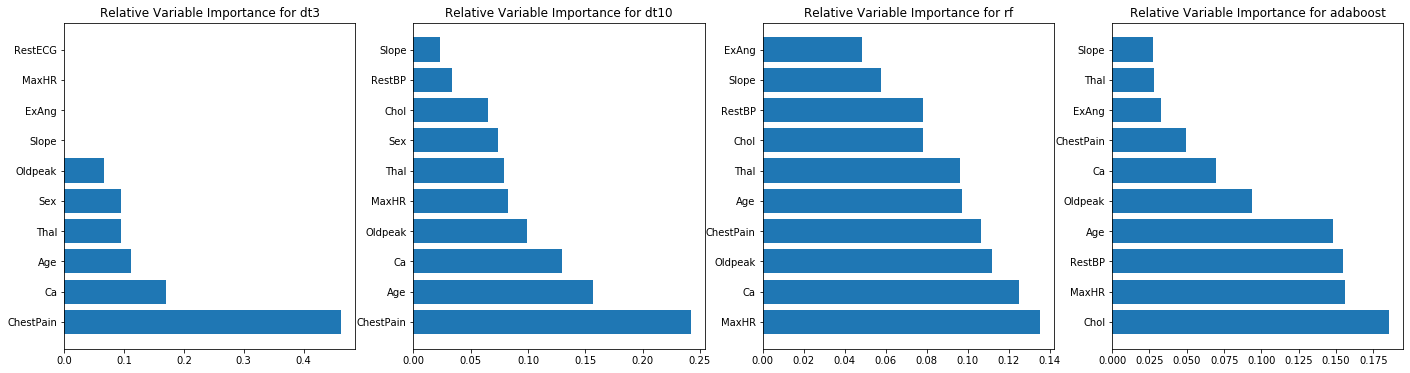

In [18]:
#Default Variable Importance

plt.figure(figsize=(24,6))
#plt.set_xticks()
#plt.set_xticklabels(X.columns)
num=10 

plt.subplot(1, 4, 1)
dt3_importances = dt3.feature_importances_
order = np.flip(np.argsort(dt3_importances))[0:num]
plt.barh(range(num),dt3_importances[order],tick_label=X.columns[order]);
plt.title("Relative Variable Importance for dt3")

plt.subplot(1, 4, 2)
dt10_importances = dt10.feature_importances_
order = np.flip(np.argsort(dt10_importances))[0:num]
plt.barh(range(num),dt10_importances[order],tick_label=X.columns[order]);
plt.title("Relative Variable Importance for dt10")

plt.subplot(1, 4, 3)
rf_importances = randomforest.feature_importances_
order = np.flip(np.argsort(rf_importances))[0:num]
plt.barh(range(num),rf_importances[order],tick_label=X.columns[order]);
plt.title("Relative Variable Importance for rf")

plt.subplot(1, 4, 4)
adaboost_importances = adaboost.feature_importances_
order = np.flip(np.argsort(adaboost_importances))[0:num]
plt.barh(range(num),adaboost_importances[order],tick_label=X.columns[order]);
plt.title("Relative Variable Importance for adaboost");



**Q3.1** Interpret the plots above: why do they make sense?  How would the random forest variable imporance change if `max_features` was altered?

**Solution:**

The plots make sense: the decision tree of depth 3 has all of its splits defined by just a handful of variables as there are only 7 splits in this tree.  The tree of depth 10 has a lot of importance on just one variable (`ChestPain`, with relative importance of about 0.26), which defines the most influential splits on MSE when building the tree.  The random forest and adaboost both have a lot more uniformly spread-out importance, which makes sense since the random forest there are some base trees that do not consider `ChestPain` in the first splits, and in adaboost, the learning rate reduces the influence that any one single split contributes to the reduciton of MSE.

Below we use the [`eli5`](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance) package to perform permutation importance for the random forest model.  

In [19]:
#pip install eli5
#permutation importance
import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances


perm = PermutationImportance(randomforest).fit(X_test, y_test)
#eli5.show_weights(perm,feature_names=X.columns)
print(X.columns)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/kevinrader/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Index(['Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
       'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal'],
      dtype='object')


Weight,Feature
0.1148 ± 0.0622,Ca
0.0525 ± 0.0321,Thal
0.0426 ± 0.0334,ChestPain
0.0230 ± 0.0393,Oldpeak
0.0197 ± 0.0245,Sex
0.0197 ± 0.0525,ExAng
0.0098 ± 0.0334,Slope
0.0098 ± 0.0161,Chol
0.0098 ± 0.0334,Age
0 ± 0.0000,Fbs


**Q3.2** How do the permutation importances compare to the default feature importance?  What is the difference in interpretation?

`ChestPain` is still the most influential, but `Thal` was the second most important based on relative importance, but is near the bottom in the permutation importance.  This indicates (and can be explained by the dfact) that this variable is highly correlated with other predictors used in the model.

In [20]:

#Note: eli5 does not behave well with Keras, by default.

perm = PermutationImportance(model_NN, random_state=1).fit(X_train,y_train)


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x1a38bd3390> does not.

In [21]:
#Note: eli5 does not behave well with Keras, by default.  But a user-


def score(model,X, y):
    y_pred = model.predict(X)
    return sk.metrics.accuracy_score(y, y_pred>0.5)

perm = PermutationImportance(model_NN, scoring=score, random_state=1).fit(X_train,y_train)

eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.0744 ± 0.0309,MaxHR
0.0430 ± 0.0349,Ca
0.0298 ± 0.0399,RestBP
0.0207 ± 0.0105,Thal
0.0198 ± 0.0096,Sex
0.0107 ± 0.0248,Oldpeak
0.0099 ± 0.0112,ChestPain
0.0041 ± 0.0209,ExAng
0 ± 0.0000,Fbs
-0.0017 ± 0.0134,Age


## Part 4: Plotting Predictions


Below we start to interpret relationships from various models based on the predictions from those models

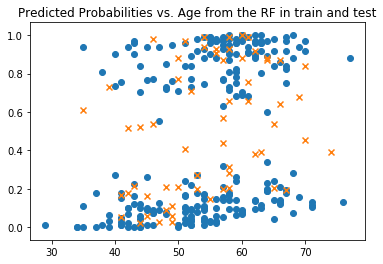

In [22]:
yhat_rf_train = randomforest.predict_proba(X_train)[:,1]
plt.scatter(X_train[['Age']],yhat_rf_train);
yhat_rf_test = randomforest.predict_proba(X_test)[:,1]
plt.scatter(X_test[['Age']],yhat_rf_test,marker='x');
plt.title("Predicted Probabilities vs. Age from the RF in train and test");

**Q4.1** What does the above plot showing?  How can it be interpreted?

**Solution:**

This plot shows that there is not much directional relationship being predicted between Age and AHD in the random forest model.  It does suggest there are 2 subgroups being predicted in the train set (one gorup near a probability of zero and one group near 1) which suggests a categorical predictor is causing these differences in predicted values (likely `ChestPain` is the culprit).

**Q4.1** Reproduce the above plot for your neural netowrk model.  How does it compare?  What does it say about Age's relationship with Cardiac Arrest?

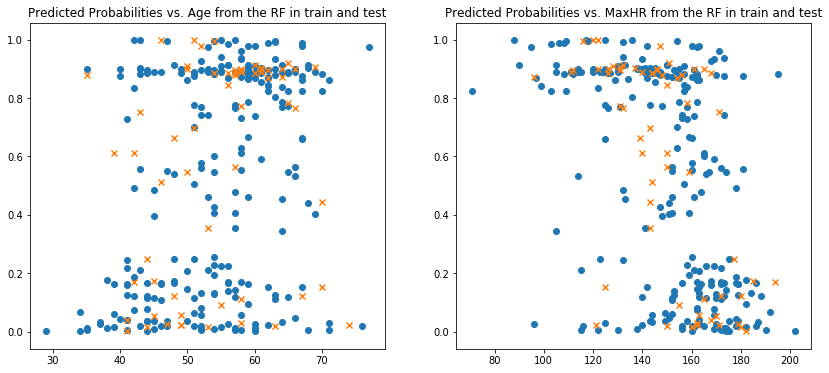

In [23]:
######
# Your code here
# Note: we also show it for a stronger predictor: MaxHR
######
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
yhat_nn_train = model_NN2.predict(X_train)
plt.scatter(X_train[['Age']],yhat_nn_train);
yhat_nn_test = model_NN2.predict(X_test)
plt.scatter(X_test[['Age']],yhat_nn_test,marker='x');
plt.title("Predicted Probabilities vs. Age from the RF in train and test");

plt.subplot(1, 2, 2)
yhat_nn_train = model_NN2.predict(X_train)
plt.scatter(X_train[['MaxHR']],yhat_nn_train);
yhat_nn_test = model_NN2.predict(X_test)
plt.scatter(X_test[['MaxHR']],yhat_nn_test,marker='x');
plt.title("Predicted Probabilities vs. MaxHR from the RF in train and test");

**Q4.3** Fit a logistic regression to the predicted response from your NN model based on Age (in train).  Interpret the result

In [24]:
from sklearn.linear_model import LogisticRegression

######
# your code here
######
logit = LogisticRegression(C=10000)
logit.fit(X_test[['Age']],np.ravel(1*(yhat_nn_test>0.5)))
logit.coef_



array([[0.03533349]])

**Solution:**

The estimated $\hat{\beta}_1$ is estimated to be 0.10255, which suggests a positive relationship, on average.  A 1-year increase is associated with a $e^{0.10255}=1.108$ multiplicative increase (a 10.8% increase) in the odds of having a cardiac event on average based on the Neural Network model.  

Below, several different plots are created:
1. The predicted probabilities vs. age for any reasonable value of age at the mean values for the other predictors
2. The predicted probabilties for each individual vs. Age (sometimes called profile plots) and the averaged individual probabilities vs. Age.
3. The median of these individual predcited probability curves, along with the middle 95% ranges at any particular value of Age.

In [25]:
means1 = X_train.mean(axis = 0)
#means1 =pd.Series(means)
means_df = (means1.to_frame()).transpose()
#df_repeated = pd.concat(means*3)
#print(df_repeated)
Ages = np.arange(np.min(X['Age']),np.max(X['Age']))
means_df  = pd.concat([means_df]*Ages.size,ignore_index=True)
means_df['Age'] = Ages
means_df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
0,29,0.665289,0.896694,131.264463,246.702479,0.144628,0.975207,149.904959,0.309917,1.054132,1.603306,0.661157,1.322314
1,30,0.665289,0.896694,131.264463,246.702479,0.144628,0.975207,149.904959,0.309917,1.054132,1.603306,0.661157,1.322314
2,31,0.665289,0.896694,131.264463,246.702479,0.144628,0.975207,149.904959,0.309917,1.054132,1.603306,0.661157,1.322314
3,32,0.665289,0.896694,131.264463,246.702479,0.144628,0.975207,149.904959,0.309917,1.054132,1.603306,0.661157,1.322314
4,33,0.665289,0.896694,131.264463,246.702479,0.144628,0.975207,149.904959,0.309917,1.054132,1.603306,0.661157,1.322314


Instructions for updating:
Please use `model.predict()` instead.


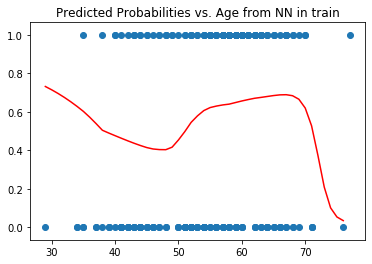

In [26]:
#plots at means
yhat_nn = model_NN2.predict_proba(means_df)
plt.scatter(X_train['Age'],y_train)
plt.plot(means_df['Age'],yhat_nn,color="red")
plt.title("Predicted Probabilities vs. Age from NN in train");

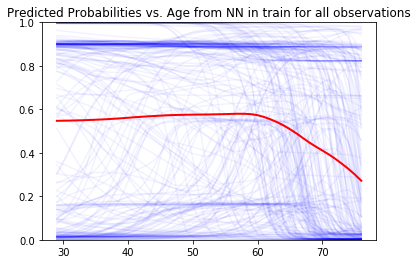

In [27]:
#Plots for all pobservations.  And then averaged

means1 = X_train.mean(axis = 0)
#means1 =pd.Series(means)
means_df = (means1.to_frame()).transpose()
#df_repeated = pd.concat(means*3)
#print(df_repeated)
Ages = np.arange(np.min(X['Age']),np.max(X['Age']))
means_df  = pd.concat([means_df]*Ages.size,ignore_index=True)
means_df['Age'] = Ages
yhat_nns = []
for i in range(0,X_train.shape[0]):
    obs = X_train.iloc[i,:].to_frame().transpose()
    obs_df  = pd.concat([obs]*Ages.size,ignore_index=True)
    obs_df['Age'] = Ages
    yhat_nn = model_NN2.predict_proba(obs_df)
    yhat_nns.append(yhat_nn.transpose())
    plt.plot(obs_df['Age'],yhat_nn,color='blue',alpha=0.05)

plt.plot(obs_df['Age'],np.mean(yhat_nns,axis=0)[0],color='red',linewidth=2);
    
plt.ylim(0,1)
plt.title("Predicted Probabilities vs. Age from NN in train for all observations");

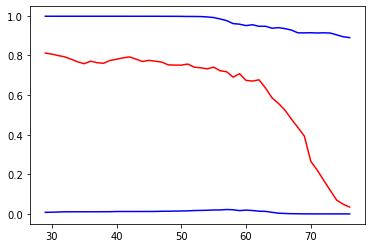

In [28]:
plt.plot(obs_df['Age'],np.median(yhat_nns,axis=0)[0],color='red');
plt.plot(obs_df['Age'],np.quantile(yhat_nns,q=.05,axis=0)[0],color='blue');
plt.plot(obs_df['Age'],np.quantile(yhat_nns,q=.95,axis=0)[0],color='blue');


**Q4.4** Interpret these plots.  What does the NN model say about the relationship between age and chances of cardiac arrest?

**Solution:**

The first plot is the estimated prediction curve when means for the other variables are plugged in (note the header of the `means_df` dataframe shown a few cells earlier), while the second figure plots all the prediction curves holding the other predictors constant at each observable combination within actual observations.  The third plot just illustrates the median of these individual prediction curves, along with the middle 90% of the distribution of these curves at any particular Age.

This model suggests that the relationship with age is actually slightly negative on average, however there are a lot of estimated individual curves (the blue curves in the second plot) that are positive and negative sloping, suggesting that there may be interactive effects of the other variables with age.

**Q4.5** Why is it important to consider plotting for separate individuals rather than just doing the predictions at the mean value for the other predictors?

**Solution:**

The second plot can illustrate interactive effects and or highlight that the relationship may be strong for some individuals, but not for an individual who happens to be at the mean or median of the other predictors used in the model.